# PyTorch Workflow

1. data (preprocess and load)
2. build model
3. fitting the model to data (training)
4. making predictions and evaluating a model (inference)
5. saving and loading a model
6. putting it all together

In [1]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for beyral networks
import matplotlib.pyplot as plt

torch.__version__


'2.3.0+cu121'

## 1. Data (preparing and loading)

Data can be almost anything ... in ML

* Excel spreadhseet
* Images of any kind
* Vidoes (YouTube has lots of data)
* Audio like songs or podcasts
* DNA
* Text

Machine learning ia a game of two parts

1.  Get data into a numerical representation
2.  Build a model to learn patterns in that numercial representation

To showxase this, lets create some *known* data using the linear regression formula

We'll use a linear regression formula to make a staright line with *known* **parameters**.

In [2]:
# Create *known* parameters
weight=0.7
bias=0.3

#Create
start=0;
end=1;
step=0.02
X=torch.arange(start,end,step).unsqueeze(dim=1)
y=weight*X+bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

### Splitting data into trining and test sets (one of the most importantconcepts in ML in general)

Lets create training and testing data
sckit can also be used to randomly split the data

In [3]:
# Create a train/test split

train_split=int(0.8 * len(X))
X_train,y_train=X[:train_split], y[: train_split]
X_test,y_test=X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

How might we better visualize aur data?

This is where the data explorer's motto comes in !'
"Visualize!"

In [4]:
def plot_predictions(train_data=X_train, train_labels=y_train,
                     test_data=X_test, test_lables=y_test,predictions=None):
  """
  Plots traning data, test data and compare predcitions
  """
  plt.figure(figsize=(10,7))

  #Plot traning data in blue
  plt.scatter(train_data, train_labels,c="b",s=4, label="Traning data")

  #Plot traning data in green
  plt.scatter(test_data, test_lables,c="g",s=4, label="Testing data")

  # Are there predictions?
  if predictions is not None:
    #Plot the predictions if they exists
    plt.scatter(test_data,predictions,c="r",s=4, label="Predictions")

  #Show the legend
  plt.legend(prop={"size":14})



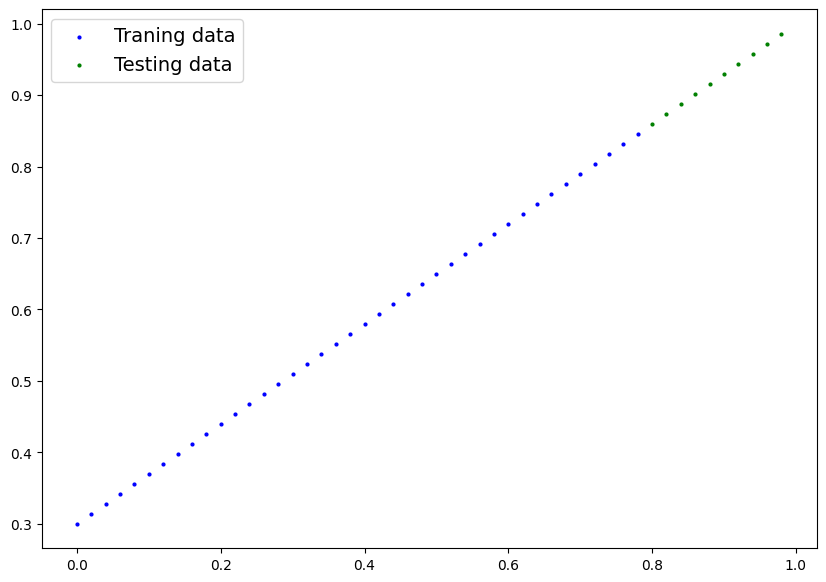

In [5]:
plot_predictions()

## 2. Build Model

Our first Model

What our model does:
* Start with random values (weight & bias)
* Look at training data and adjust the random values to better represent (or to get closer to) the ideal values (the weight & bias values we used to create the data)

How does it do so?

Throught two main algos:
1. Gradiesnt descent
2. Backpropagation

In [6]:
# Create linear regression model class

class LinearRegressionModel(nn.Module): ## <- almost everything in PyTorch inherits from nn.Module
  def __init__(self):
    super().__init__()
    self.weights=nn.Parameter(torch.randn(1,requires_grad=True,
                                          dtype=torch.float))
    self.bias=nn.Parameter(torch.randn(1,requires_grad=True,dtype=torch.float))

    #Forward method to define the computation in the model
  def forward(self, x: torch.Tensor) ->torch.Tensor: #x is input data
    return self.weights*x +self.bias






### PyTorch model builing essentials

1. torch.nn -> contains all the builing blocks for computational graphs ) a neural netowkr can be considered computational graph)
2. torch.Parameter -> what parameters should our model try and learn, often a Pytorch layer from torch.nn will set these for us
3. torch.nn.Module -> base class for all neural networks, if you subclass it, you should override forward()
4. torch.optim -> this where the optimizers in PyTorch live, they will help with graident descent
5. def forward() -> All nn.module subclass requires you to overide  forward(), this method defines what happens in the forward computation
6. torch.utils.data.Dataset
7. torch.utils.data.DataLoader
8. torchvision.transforms (later in CV)
9. torchvision.models
10. torchmetrics
11. torch.utils.tensorboard


### Checking the contents of the PyTorch model

So we can check our model praramters or whats inside our model using .paramaters()

In [8]:
# Create a random seed
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module)
model_0=LinearRegressionModel()

list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [9]:
# List named paramters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making prediction using `torch.inference_mode()`

to check our model's predictive power, let's see how well it predicts `y_test`
based on `X_test`

When we pass data through our model it is going to run it through forward method

In [14]:
# Make predictions with model

with torch.inference_mode():
  y_preds=model_0(X_test)

# You can also do something similar with torch.no_grad(), however, inference mode is preferred
# with torch.no_grad():
#   y_preds=model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

In [12]:
y_test

tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

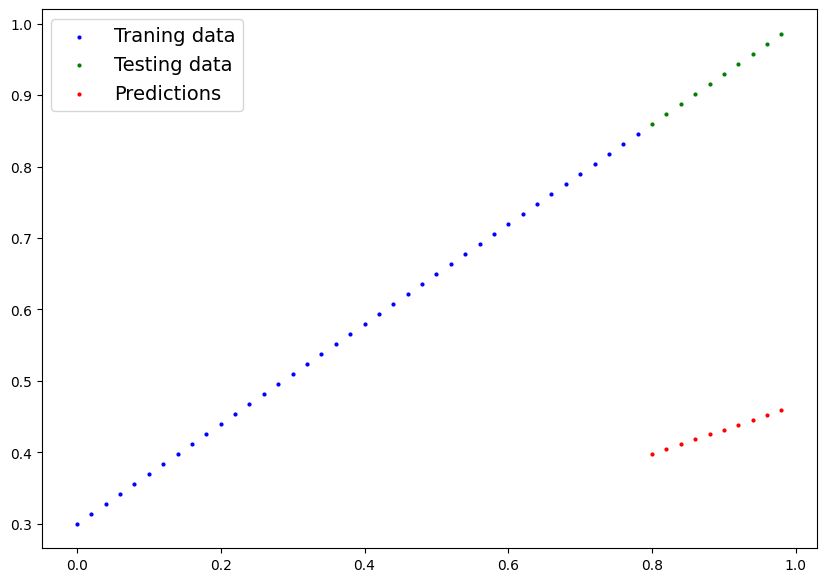

In [13]:
plot_predictions(predictions=y_preds)

## 3. Train model

The whole idea of traning is for a model to move from some *unknown* parameters
(these may be random) to *known* paramters.
Or
From a poor reprsentation of the data to a batter representation of the data_parallel

One way to measure how poor or how wrong your models predictions are is to use a
loss function.

*Note* : Loss func may also be called cost func or criterion in diff areas. For our case, we're going to refer to it as a loss function.

This we need to train-

* **Loss function:** A function to measure how wrong your model's predictions are to the ideal outputs, lower is better

* **Optimizer:** Takes into account the loss of a model and adjusts the model's paramters (eg weight and bias in our case) to improve the loss func.

Ans specifically for PyTorch, we need:

* A traning loop
* A testing loop


In [15]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])